# Feature Engineering

In this file, I will be doing some feature engineering. Some processes will go into the dataframe_utils.py file and into a function called feature_engineer(df) for code reusability.

- Clean the dataframe and split into training and test set.
- Perform one hot encoding for categorical features with the dummy variable trap in mind. 
- Add new features:
    First I want to measure the distance between ball bounce and where the returner is positioned in three ways:
    - x-displacement between ball bounce and returner's position: if this distance is large then returner has to move more along the baseline to hit the ball
    - y-displacement between ball bounce and returner's position
    - total distance between ball bounce and returner's position

    Next I want to measure how good a serve is by seeing how close it is to the lines: using arbitrary measure of closeness as 10cm (setting tolerence = 10cm). If close, the value is 1, else 0.
    - close_to_side_line
    - close_to_center_line: ie down the T
    - close_to_service_line
- Scale the data: Use both Robust and Standard scaling as the features have different distributions.
- Use the correlation matrix to see which features have high positive or negative correlation. Use domain knowledge to drop or preserve features. Using a threshold of 0.9 (absolute value).    

In [1]:
# Import everything from my_libraries.py
from my_libraries import *

# Other utilities
import tennis_utils
import dataframe_utils

In [2]:
# Read into dataframe
df = pd.read_csv("datasets/task_set.csv")

# Clean dataframe
df = dataframe_utils.clean_dataframe(df)

In [3]:
df

,surface,serve_side,serve_number,ball_hit_y,ball_hit_x,ball_hit_z,ball_hit_v,ball_net_v,ball_net_z,ball_net_y,ball_bounce_x,ball_bounce_y,ball_bounce_v,ball_bounce_angle,hitter_x,hitter_y,receiver_x,receiver_y,hitter_hand,receiver_hand,is_ace
0,hard,deuce,2,-1.459,-11.445,2.830,91.5,67.9,1.241,0.980,4.392,2.278,60.7,19.216,-11.739,-1.398,13.343,3.570,right,left,0
1,hard,ad,1,1.083,-11.228,2.817,125.5,97.7,1.019,-0.026,4.528,-0.618,88.8,12.428,-11.744,1.131,15.459,-4.067,left,right,0
2,hard,deuce,1,-0.835,-11.149,2.793,109.7,85.5,1.156,2.082,5.378,3.744,75.3,12.737,-11.538,-0.647,13.679,3.544,right,right,0
3,clay,ad,2,1.424,-11.488,2.727,97.1,74.1,1.095,-1.170,3.915,-1.853,68.1,17.743,-11.690,1.169,11.378,-3.402,right,right,0
4,hard,ad,1,0.472,-10.985,2.660,121.0,95.7,1.094,-0.301,5.267,-0.525,85.5,12.013,-11.508,0.559,14.323,-3.629,right,right,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187921,hard,deuce,2,-0.303,-11.230,2.725,92.6,73.2,1.230,1.833,4.921,3.108,65.6,15.935,-11.573,-0.361,15.278,3.645,right,right,0
187922,hard,ad,1,0.886,-11.358,2.813,112.3,86.1,1.083,-2.094,4.636,-3.113,76.6,13.120,-11.615,0.844,13.219,-3.299,right,right,0
187923,hard,ad,1,1.395,-11.254,2.782,104.0,78.7,1.140,-2.276,4.499,-3.556,70.5,16.639,-11.625,1.050,14.470,-3.828,right,right,0
187924,clay,deuce,1,-0.623,-11.179,2.806,130.4,104.1,1.203,0.735,6.308,1.568,92.2,10.420,-11.616,-0.988,14.068,3.368,right,right,0


In [4]:
df.dtypes

surface               object
serve_side            object
serve_number           int64
ball_hit_y           float64
ball_hit_x           float64
ball_hit_z           float64
ball_hit_v           float64
ball_net_v           float64
ball_net_z           float64
ball_net_y           float64
ball_bounce_x        float64
ball_bounce_y        float64
ball_bounce_v        float64
ball_bounce_angle    float64
hitter_x             float64
hitter_y             float64
receiver_x           float64
receiver_y           float64
hitter_hand           object
receiver_hand         object
is_ace                 int64
dtype: object

# Split data into train and test.

In [5]:
# Split data while maintaining the proportion of 'is_ace'
X = df.drop("is_ace", axis=1)
y = df["is_ace"]

# Perform stratified split using train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Save the train dataset in a new csv file
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.to_csv("datasets/train_dataset.csv")

In [6]:
# Impute missing values
for data in (X_train, X_test):
    data = dataframe_utils.impute_data(data)

In [7]:
X_train.isna().sum()

surface              0
serve_side           0
serve_number         0
ball_hit_y           0
ball_hit_x           0
ball_hit_z           0
ball_hit_v           0
ball_net_v           0
ball_net_z           0
ball_net_y           0
ball_bounce_x        0
ball_bounce_y        0
ball_bounce_v        0
ball_bounce_angle    0
hitter_x             0
hitter_y             0
receiver_x           0
receiver_y           0
hitter_hand          0
receiver_hand        0
dtype: int64

# One hot encoding, with dummy variable trap

In [8]:
# Categorical columns to encode
categorical_columns = ["surface", "serve_side", "hitter_hand", "receiver_hand"]

# Specify which category to drop for each feature to maintain consistency
drop_categories = {
    "surface": "grass",
    "serve_side": "ad",
    "hitter_hand": "right",
    "receiver_hand": "right",
}

# Create OneHotEncoder with manual category drop
encoder = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(
                drop=[drop_categories[col] for col in categorical_columns],
                handle_unknown="ignore",
                sparse_output=False,
            ),
            categorical_columns,
        )
    ],
    remainder="passthrough",  # Keep numerical columns unchanged
)


In [9]:
# Fit encoder on training data
encoder.fit(X_train)
X_train = encoder.transform(X_train)
# Get clean feature names by removing 'cat__' and 'remainder__'
original_feature_names = encoder.get_feature_names_out()
clean_feature_names = [name.split("__")[-1] for name in original_feature_names]

X_train_df = pd.DataFrame(X_train, columns=clean_feature_names, dtype=float)

# Save the encoder to a file
joblib.dump(encoder, "one_hot_encoder.pkl")

['one_hot_encoder.pkl']

In [10]:
# Load encoder
loaded_encoder = joblib.load("one_hot_encoder.pkl")
# Transform data
X_test = loaded_encoder.transform(X_test)
# Get clean feature names by removing 'cat__' and 'remainder__'
original_feature_names = encoder.get_feature_names_out()
clean_feature_names = [name.split("__")[-1] for name in original_feature_names]

X_test_df = pd.DataFrame(X_test, columns=clean_feature_names, dtype=float)

In [11]:
X_test_df

,surface_clay,surface_hard,serve_side_deuce,hitter_hand_left,receiver_hand_left,serve_number,ball_hit_y,ball_hit_x,ball_hit_z,ball_hit_v,ball_net_v,ball_net_z,ball_net_y,ball_bounce_x,ball_bounce_y,ball_bounce_v,ball_bounce_angle,hitter_x,hitter_y,receiver_x,receiver_y
0,0.0,1.0,1.0,0.0,0.0,2.0,-0.284,-11.569,2.808,95.3,75.1,1.053,0.342,4.002,0.785,69.2,16.877,-11.864,-0.648,13.949,3.955
1,0.0,1.0,1.0,0.0,0.0,1.0,-0.439,-11.623,2.814,107.6,83.1,1.300,2.159,5.845,3.883,72.9,14.904,-11.936,-0.141,15.006,3.970
2,0.0,1.0,1.0,0.0,0.0,1.0,-0.839,-11.301,2.750,116.8,93.6,1.161,0.143,5.751,0.705,83.9,11.413,-11.740,-0.905,13.905,3.608
3,0.0,1.0,1.0,1.0,0.0,1.0,-0.610,-11.323,2.880,114.6,90.7,0.981,0.819,4.191,1.272,83.0,13.201,-12.010,-0.969,15.140,3.441
4,0.0,1.0,1.0,1.0,1.0,2.0,-0.718,-11.669,2.664,82.3,62.0,1.197,1.912,4.483,2.564,55.7,19.777,-11.883,-0.553,14.752,3.822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49298,0.0,1.0,0.0,0.0,0.0,1.0,0.784,-11.381,2.831,117.6,90.7,1.153,-2.469,5.425,-3.757,69.5,13.295,-11.625,0.881,16.245,-3.822
49299,0.0,1.0,0.0,1.0,0.0,1.0,1.444,-11.657,2.715,106.8,83.1,1.047,0.389,4.810,-0.153,74.5,13.264,-12.047,1.461,14.563,-4.045
49300,0.0,1.0,0.0,1.0,0.0,1.0,0.837,-11.446,2.864,117.3,90.6,1.065,0.187,4.905,-0.191,67.9,13.414,-11.657,0.432,13.196,-3.498
49301,1.0,0.0,0.0,1.0,0.0,1.0,1.216,-11.306,2.776,110.3,87.2,1.303,-1.616,5.962,-3.426,76.8,14.967,-11.740,1.229,14.719,-4.357


# New features

First I want to measure the distance between ball bounce and where the returner is positioned in three ways:
- x-displacement between ball bounce and returner's position: if this distance is large then returner has to move more along the baseline to hit the ball
- y-displacement between ball bounce and returner's position
- total distance between ball bounce and returner's position

Next I want to measure how good a serve is by seeing how close it is to the lines: using arbitrary measure of closeness as 10cm (setting tolerence = 10cm). If close, the value is 1, else 0.
- close_to_side_line
- close_to_center_line: ie down the T
- close_to_service_line

### Displacement - ball bounce position and returner's position

In [12]:
df = X_train_df
df["dist_ball_bounce_x_returner_x"] = abs(df["ball_bounce_x"] - df["receiver_x"])
df["dist_ball_bounce_y_returner_y"] = abs(df["ball_bounce_y"] - df["receiver_y"])
df["dist_ball_bounce_returner_total"] = np.sqrt(
    df["dist_ball_bounce_x_returner_x"] ** 2 + df["dist_ball_bounce_y_returner_y"] ** 2
)

In [13]:
df

,surface_clay,surface_hard,serve_side_deuce,hitter_hand_left,receiver_hand_left,serve_number,ball_hit_y,ball_hit_x,ball_hit_z,ball_hit_v,ball_net_v,ball_net_z,ball_net_y,ball_bounce_x,ball_bounce_y,ball_bounce_v,ball_bounce_angle,hitter_x,hitter_y,receiver_x,receiver_y,dist_ball_bounce_x_returner_x,dist_ball_bounce_y_returner_y,dist_ball_bounce_returner_total
0,1.0,0.0,0.0,0.0,0.0,1.0,1.603,-11.350,2.754,111.3,91.4,1.003,0.038,4.625,-0.510,82.1,15.054,-11.472,1.535,15.197,-3.570,10.572,3.060,11.005943
1,0.0,1.0,1.0,0.0,0.0,1.0,-1.169,-11.059,2.950,128.9,100.8,1.198,0.406,5.669,1.287,89.1,12.148,-11.514,-1.011,15.274,3.867,9.605,2.580,9.945473
2,1.0,0.0,0.0,0.0,0.0,1.0,0.235,-11.089,2.852,124.7,102.2,1.193,-0.448,5.742,-0.714,91.1,12.711,-11.612,0.751,15.802,-1.933,10.060,1.219,10.133586
3,0.0,1.0,1.0,0.0,1.0,1.0,-1.088,-11.364,2.903,116.3,90.0,1.198,1.926,5.299,3.543,80.4,15.177,-11.639,-0.953,14.103,3.755,8.804,0.212,8.806552
4,0.0,1.0,1.0,1.0,0.0,2.0,-0.861,-11.212,2.797,104.1,79.2,1.078,0.117,4.185,0.227,71.6,15.955,-11.831,-0.883,15.664,3.412,11.479,3.185,11.912668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115033,0.0,1.0,0.0,0.0,0.0,1.0,1.153,-11.390,2.862,130.7,103.9,1.089,0.118,5.329,-0.275,93.6,11.247,-11.863,1.060,13.948,-3.592,8.619,3.317,9.235240
115034,0.0,1.0,0.0,0.0,0.0,1.0,0.907,-11.323,2.888,110.0,87.1,1.200,-1.892,5.332,-3.025,78.2,14.748,-11.957,1.027,13.725,-3.670,8.393,0.645,8.417748
115035,1.0,0.0,1.0,0.0,0.0,2.0,-1.214,-11.067,2.715,104.1,86.1,1.100,0.012,5.009,0.749,78.3,13.325,-11.360,-0.839,15.246,4.262,10.237,3.513,10.823000
115036,0.0,1.0,0.0,0.0,0.0,1.0,1.409,-11.309,2.854,124.1,96.9,1.025,-0.329,4.831,-1.094,87.7,13.065,-11.510,1.046,13.310,-3.621,8.479,2.527,8.847552


### How close is ball bounce to the lines?

In [14]:
tolerance = 0.10  # Setting tolerance of 10cm
df["close_to_side_line"] = df["ball_bounce_y"].apply(
    lambda y_coord: 1
    if (
        (y_coord >= singles_sideline_y - tolerance)
        | (y_coord <= -singles_sideline_y + tolerance)
    )
    else 0
)
df["close_to_center_line"] = df["ball_bounce_y"].apply(
    lambda y_coord: 1 if ((y_coord >= -tolerance) & (y_coord <= tolerance)) else 0
)
df["close_to_service_line"] = df["ball_bounce_x"].apply(
    lambda x_coord: 1 if (x_coord >= service_line_x - tolerance) else 0
)

In [15]:
df1 = df[
    [
        "ball_bounce_x",
        "ball_bounce_y",
        "close_to_side_line",
        "close_to_center_line",
        "close_to_service_line",
    ]
]
df1

,ball_bounce_x,ball_bounce_y,close_to_side_line,close_to_center_line,close_to_service_line
0,4.625,-0.510,0,0,0
1,5.669,1.287,0,0,0
2,5.742,-0.714,0,0,0
3,5.299,3.543,0,0,0
4,4.185,0.227,0,0,0
...,...,...,...,...,...
115033,5.329,-0.275,0,0,0
115034,5.332,-3.025,0,0,0
115035,5.009,0.749,0,0,0
115036,4.831,-1.094,0,0,0


In [16]:
df2 = df1[
    df1[["close_to_side_line", "close_to_center_line", "close_to_service_line"]].any(
        axis=1
    )
]

In [17]:
df2

,ball_bounce_x,ball_bounce_y,close_to_side_line,close_to_center_line,close_to_service_line
31,4.369,4.048,1,0,0
34,6.413,-0.651,0,0,1
43,6.327,3.776,0,0,1
62,6.462,0.628,0,0,1
73,6.227,4.056,1,0,0
...,...,...,...,...,...
114984,5.969,0.007,0,1,0
114985,6.351,-1.083,0,0,1
115011,6.491,-1.560,0,0,1
115013,6.351,0.927,0,0,1


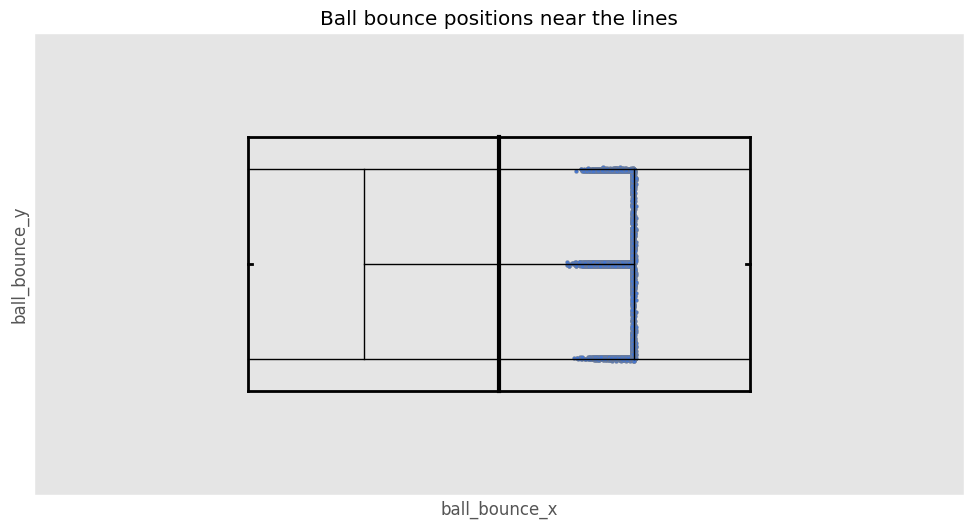

In [18]:
fig, ax = tennis_utils.draw_tennis_court()

# Plot ball bounce point (x,y)
sns.scatterplot(
    data=df2,
    x="ball_bounce_x",
    y="ball_bounce_y",
    edgecolor="gray",
    s=8,
)

# Aesthetics
ax.set_xlim(-22, 22)
ax.set_ylim(-10, 10)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlabel("Court Length (m)")
# ax.set_ylabel("Court Width (m)")
ax.set_title("Ball bounce positions near the lines")

plt.show()

### Binning certain columns and taking mean

In [19]:
df

,surface_clay,surface_hard,serve_side_deuce,hitter_hand_left,receiver_hand_left,serve_number,ball_hit_y,ball_hit_x,ball_hit_z,ball_hit_v,ball_net_v,ball_net_z,ball_net_y,ball_bounce_x,ball_bounce_y,ball_bounce_v,ball_bounce_angle,hitter_x,hitter_y,receiver_x,receiver_y,dist_ball_bounce_x_returner_x,dist_ball_bounce_y_returner_y,dist_ball_bounce_returner_total,close_to_side_line,close_to_center_line,close_to_service_line
0,1.0,0.0,0.0,0.0,0.0,1.0,1.603,-11.350,2.754,111.3,91.4,1.003,0.038,4.625,-0.510,82.1,15.054,-11.472,1.535,15.197,-3.570,10.572,3.060,11.005943,0,0,0
1,0.0,1.0,1.0,0.0,0.0,1.0,-1.169,-11.059,2.950,128.9,100.8,1.198,0.406,5.669,1.287,89.1,12.148,-11.514,-1.011,15.274,3.867,9.605,2.580,9.945473,0,0,0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.235,-11.089,2.852,124.7,102.2,1.193,-0.448,5.742,-0.714,91.1,12.711,-11.612,0.751,15.802,-1.933,10.060,1.219,10.133586,0,0,0
3,0.0,1.0,1.0,0.0,1.0,1.0,-1.088,-11.364,2.903,116.3,90.0,1.198,1.926,5.299,3.543,80.4,15.177,-11.639,-0.953,14.103,3.755,8.804,0.212,8.806552,0,0,0
4,0.0,1.0,1.0,1.0,0.0,2.0,-0.861,-11.212,2.797,104.1,79.2,1.078,0.117,4.185,0.227,71.6,15.955,-11.831,-0.883,15.664,3.412,11.479,3.185,11.912668,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115033,0.0,1.0,0.0,0.0,0.0,1.0,1.153,-11.390,2.862,130.7,103.9,1.089,0.118,5.329,-0.275,93.6,11.247,-11.863,1.060,13.948,-3.592,8.619,3.317,9.235240,0,0,0
115034,0.0,1.0,0.0,0.0,0.0,1.0,0.907,-11.323,2.888,110.0,87.1,1.200,-1.892,5.332,-3.025,78.2,14.748,-11.957,1.027,13.725,-3.670,8.393,0.645,8.417748,0,0,0
115035,1.0,0.0,1.0,0.0,0.0,2.0,-1.214,-11.067,2.715,104.1,86.1,1.100,0.012,5.009,0.749,78.3,13.325,-11.360,-0.839,15.246,4.262,10.237,3.513,10.823000,0,0,0
115036,0.0,1.0,0.0,0.0,0.0,1.0,1.409,-11.309,2.854,124.1,96.9,1.025,-0.329,4.831,-1.094,87.7,13.065,-11.510,1.046,13.310,-3.621,8.479,2.527,8.847552,0,0,0


In [20]:
df = dataframe_utils.binning(
    df=df,
    column="ball_hit_v",
    new_column_name="bin_mean_speed",
    step_size=2.5,
    round_up=1,
    drop_old_column=True,
)

In [21]:
# # Define bin edges (adjust based on min/max serve speed)
# bin_edges = np.arange(df["ball_hit_v"].min(), df["ball_hit_v"].max() + 2.5, 2.5)

# # Create bin labels
# df["speed_binning"] = pd.cut(
#     df["ball_hit_v"], bins=bin_edges, right=False
# )  # Right=False ensures left-inclusive bins

# # Compute mean serve speed per bin
# bin_means = df.groupby("speed_binning")["ball_hit_v"].transform("mean")

# # Add new column and drop some
# df["bin_mean_speed"] = bin_means.round(1)
# df.drop(columns=["speed_binning", "ball_hit_v"], inplace=True)


In [22]:
df = dataframe_utils.binning(
    df=df,
    column="ball_hit_y",
    new_column_name="bin_mean_ball_hit_y",
    step_size=0.4,
    round_up=3,
    drop_old_column=True,
)

In [23]:
df = dataframe_utils.binning(
    df=df,
    column="ball_hit_z",
    new_column_name="bin_mean_ball_hit_z",
    step_size=0.1,
    round_up=3,
    drop_old_column=True,
)

In [24]:
df

,surface_clay,surface_hard,serve_side_deuce,hitter_hand_left,receiver_hand_left,serve_number,ball_hit_x,ball_net_v,ball_net_z,ball_net_y,ball_bounce_x,ball_bounce_y,ball_bounce_v,ball_bounce_angle,hitter_x,hitter_y,receiver_x,receiver_y,dist_ball_bounce_x_returner_x,dist_ball_bounce_y_returner_y,dist_ball_bounce_returner_total,close_to_side_line,close_to_center_line,close_to_service_line,bin_mean_speed,bin_mean_ball_hit_y,bin_mean_ball_hit_z
0,1.0,0.0,0.0,0.0,0.0,1.0,-11.350,91.4,1.003,0.038,4.625,-0.510,82.1,15.054,-11.472,1.535,15.197,-3.570,10.572,3.060,11.005943,0,0,0,111.5,1.432,2.806
1,0.0,1.0,1.0,0.0,0.0,1.0,-11.059,100.8,1.198,0.406,5.669,1.287,89.1,12.148,-11.514,-1.011,15.274,3.867,9.605,2.580,9.945473,0,0,0,129.0,-1.300,2.899
2,1.0,0.0,0.0,0.0,0.0,1.0,-11.089,102.2,1.193,-0.448,5.742,-0.714,91.1,12.711,-11.612,0.751,15.802,-1.933,10.060,1.219,10.133586,0,0,0,124.0,0.307,2.806
3,0.0,1.0,1.0,0.0,1.0,1.0,-11.364,90.0,1.198,1.926,5.299,3.543,80.4,15.177,-11.639,-0.953,14.103,3.755,8.804,0.212,8.806552,0,0,0,116.5,-0.940,2.899
4,0.0,1.0,1.0,1.0,0.0,2.0,-11.212,79.2,1.078,0.117,4.185,0.227,71.6,15.955,-11.831,-0.883,15.664,3.412,11.479,3.185,11.912668,0,0,0,104.0,-0.940,2.806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115033,0.0,1.0,0.0,0.0,0.0,1.0,-11.390,103.9,1.089,0.118,5.329,-0.275,93.6,11.247,-11.863,1.060,13.948,-3.592,8.619,3.317,9.235240,0,0,0,131.4,1.061,2.899
115034,0.0,1.0,0.0,0.0,0.0,1.0,-11.323,87.1,1.200,-1.892,5.332,-3.025,78.2,14.748,-11.957,1.027,13.725,-3.670,8.393,0.645,8.417748,0,0,0,109.0,1.061,2.899
115035,1.0,0.0,1.0,0.0,0.0,2.0,-11.067,86.1,1.100,0.012,5.009,0.749,78.3,13.325,-11.360,-0.839,15.246,4.262,10.237,3.513,10.823000,0,0,0,104.0,-1.300,2.714
115036,0.0,1.0,0.0,0.0,0.0,1.0,-11.309,96.9,1.025,-0.329,4.831,-1.094,87.7,13.065,-11.510,1.046,13.310,-3.621,8.479,2.527,8.847552,0,0,0,124.0,1.432,2.899


# Scaling

The standard scaler is used for most columns that have the normal distribution property. But there are columns that have multimode distribution, using the robust scaler for such columns.

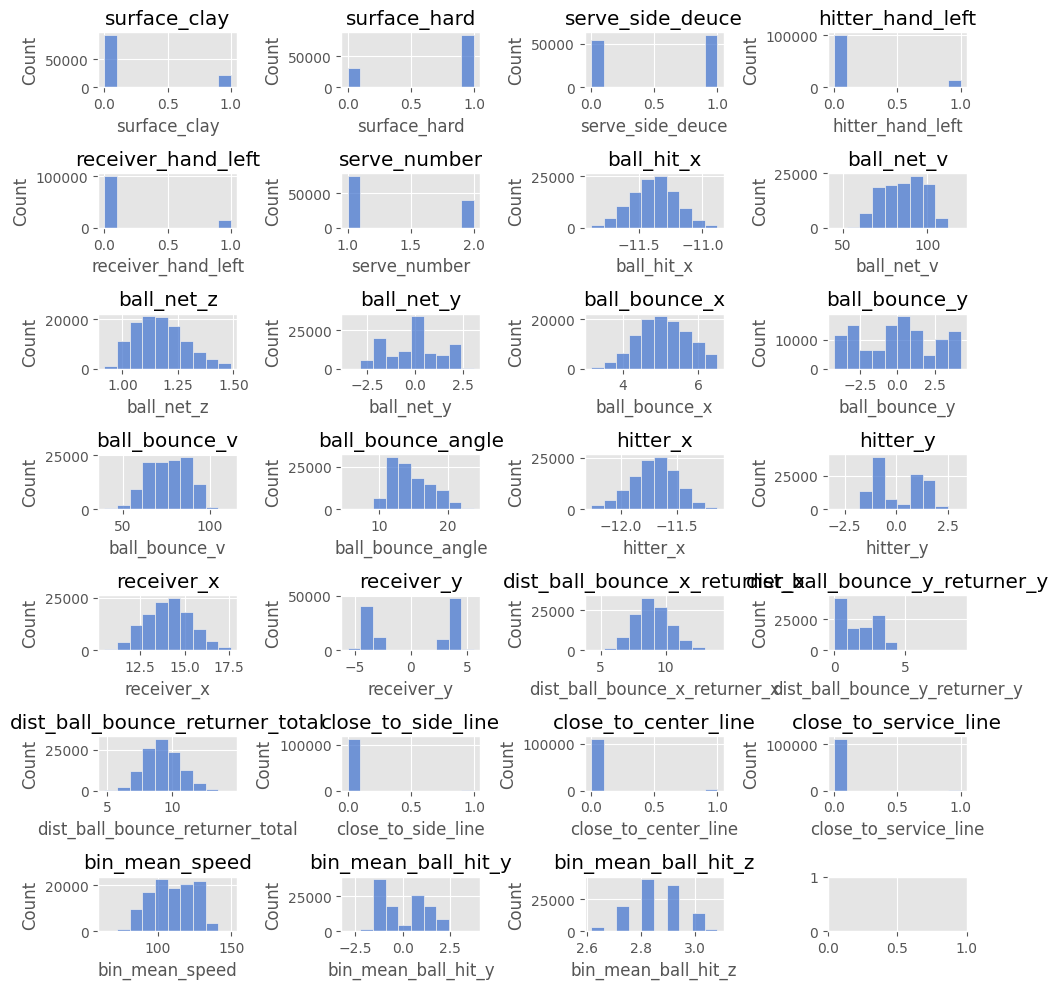

In [25]:
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(10, 10))

# Flatten axes to iterate easily
axes = axes.flatten()

# Loop over columns and axes to plot histograms
for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=axes[i], bins=10, kde=False)
    axes[i].set_title(f"{col}")
    # axes[i].set_xlabel(col)
    # axes[i].set_ylabel("Frequency")

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

In [26]:
df.columns

Index(['surface_clay', 'surface_hard', 'serve_side_deuce', 'hitter_hand_left',
       'receiver_hand_left', 'serve_number', 'ball_hit_x', 'ball_net_v',
       'ball_net_z', 'ball_net_y', 'ball_bounce_x', 'ball_bounce_y',
       'ball_bounce_v', 'ball_bounce_angle', 'hitter_x', 'hitter_y',
       'receiver_x', 'receiver_y', 'dist_ball_bounce_x_returner_x',
       'dist_ball_bounce_y_returner_y', 'dist_ball_bounce_returner_total',
       'close_to_side_line', 'close_to_center_line', 'close_to_service_line',
       'bin_mean_speed', 'bin_mean_ball_hit_y', 'bin_mean_ball_hit_z'],
      dtype='object')

In [28]:
robust_columns = ["bin_mean_ball_hit_y", "ball_bounce_y", "hitter_y", "receiver_y"]
standard_columns = [
    "ball_hit_x",
    "ball_net_v",
    "ball_net_z",
    "ball_net_y",
    "ball_bounce_x",
    "ball_bounce_v",
    "ball_bounce_angle",
    "hitter_x",
    "receiver_x",
    "dist_ball_bounce_x_returner_x",
    "dist_ball_bounce_y_returner_y",
    "dist_ball_bounce_returner_total",
    "bin_mean_speed",
    "bin_mean_ball_hit_z",
]
non_scaled_columns = [
    "surface_clay",
    "surface_hard",
    "serve_side_deuce",
    "hitter_hand_left",
    "receiver_hand_left",
    "serve_number",
    "close_to_side_line",
    "close_to_center_line",
    "close_to_service_line",
]

# Create a column transformer
scaler = ColumnTransformer(
    transformers=[
        ("robust", RobustScaler(), robust_columns),
        ("standard", StandardScaler(), standard_columns),
        ("passthrough", "passthrough", non_scaled_columns),
    ]
)

# Apply the transformations
processed_data = scaler.fit_transform(df)
# Save the scaler
joblib.dump(scaler, "scaler.joblib")
# Convert the result back to a DataFrame with appropriate column names
processed_df = pd.DataFrame(
    processed_data,
    columns=robust_columns + standard_columns + non_scaled_columns,
    dtype=float,
)

In [29]:
X_train_df = processed_df
df = X_train_df

## Correlation matrix

To avoid repetition of information, calculating the correlation matrix to drop columns that are highly positively or negatively correlated. 

In [30]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Absolute value of the correlation matrix
abs_corr_matrix = correlation_matrix.abs()
# Mask for the upper triangle
upper = abs_corr_matrix.where(np.triu(np.ones(abs_corr_matrix.shape), k=1).astype(bool))
# Identify columns to drop
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print("Dropped columns:")
print(to_drop)

Dropped columns:
['hitter_y', 'receiver_y', 'ball_net_y', 'ball_bounce_v', 'dist_ball_bounce_returner_total', 'bin_mean_speed', 'serve_side_deuce']


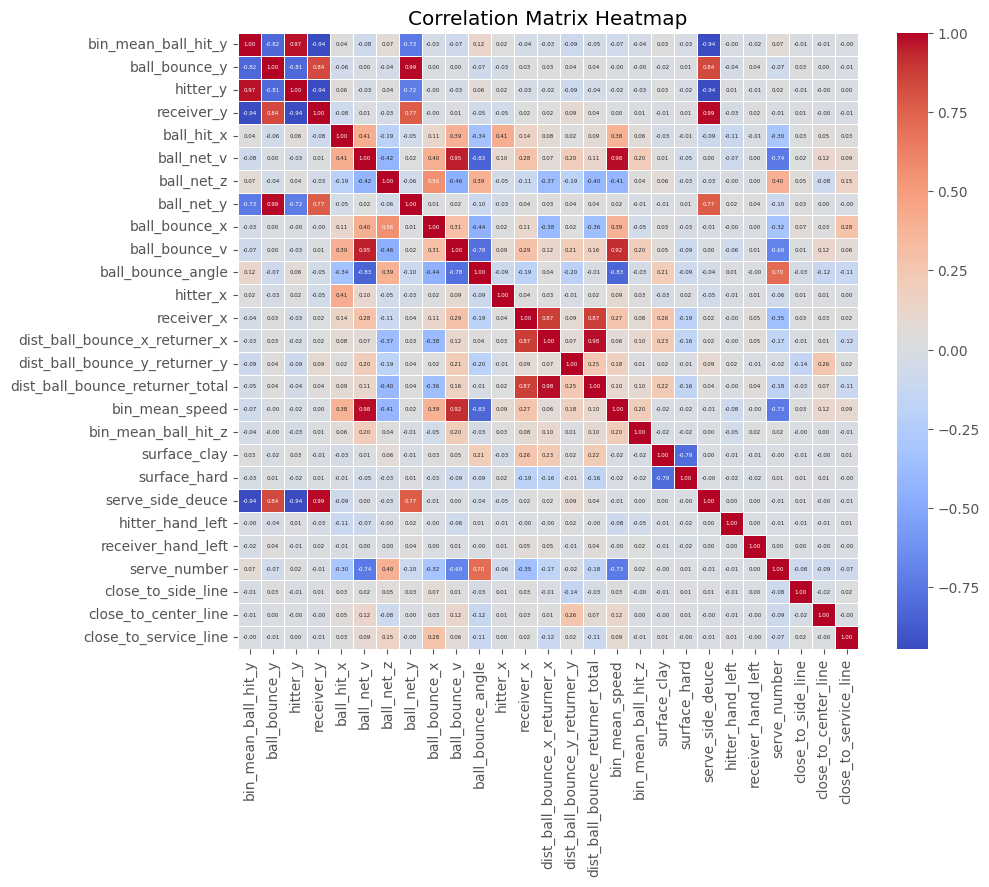

In [31]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 4},
)
plt.title("Correlation Matrix Heatmap")
plt.show()

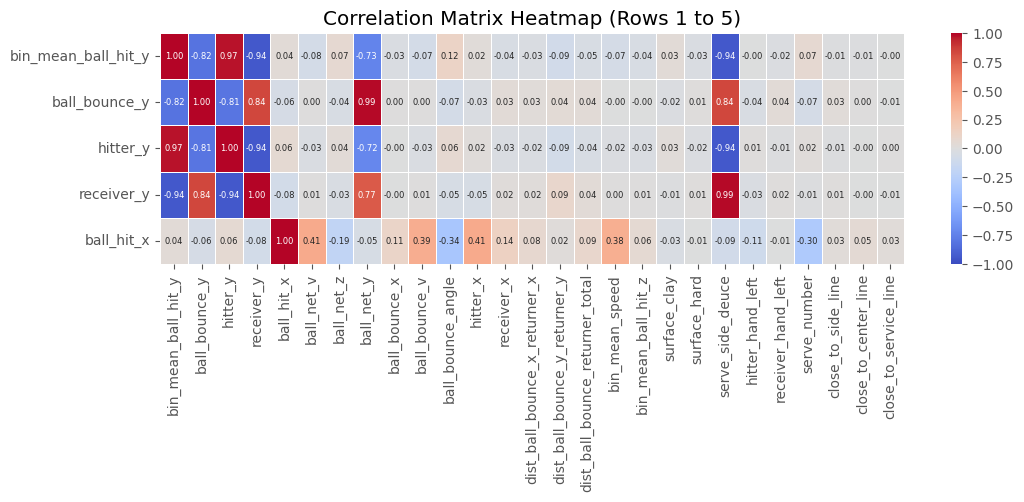

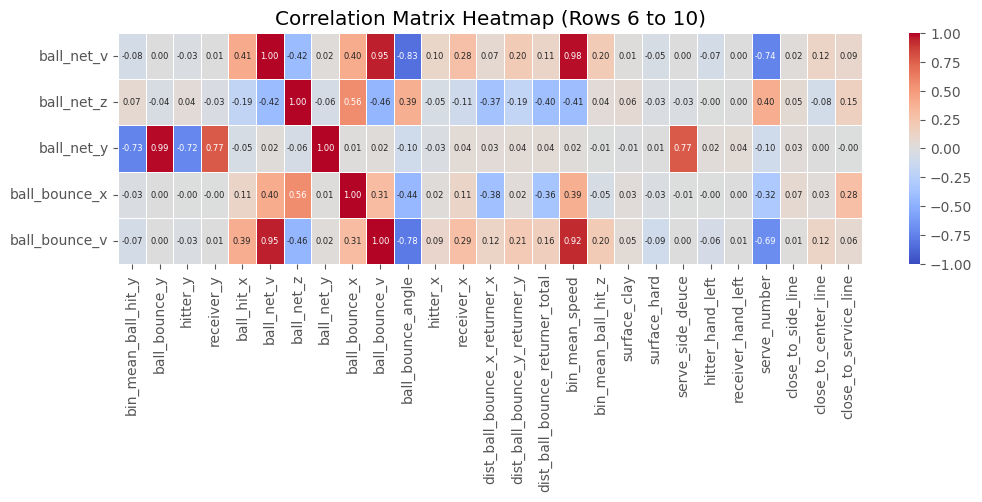

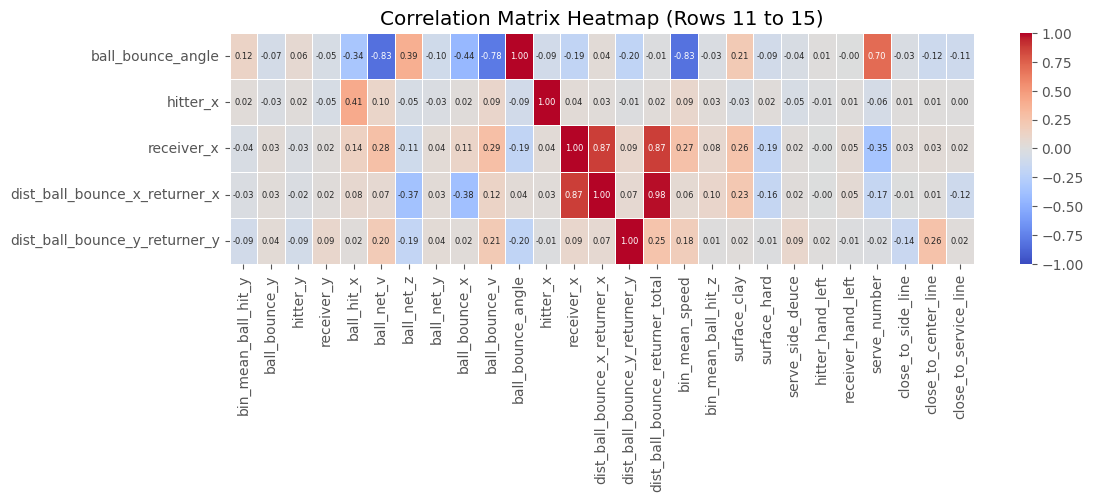

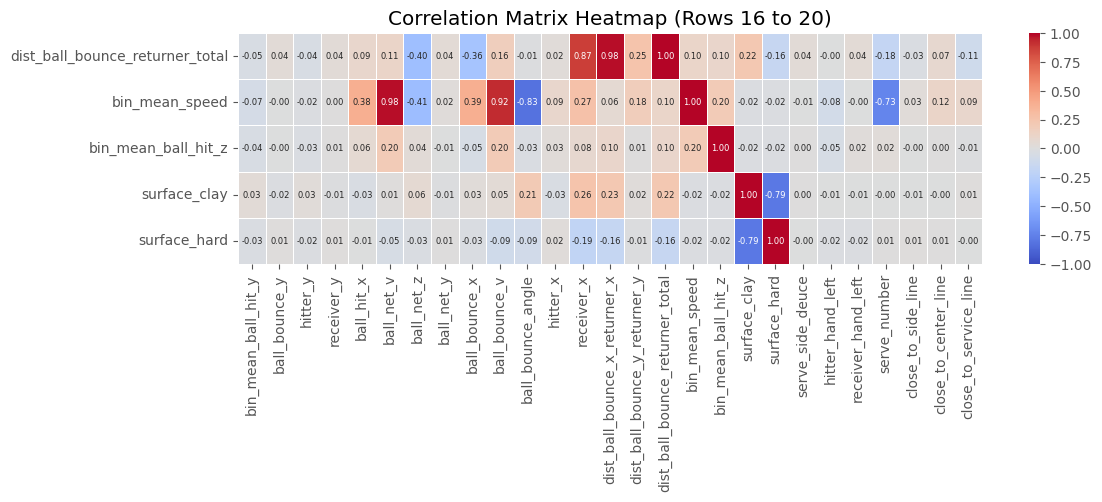

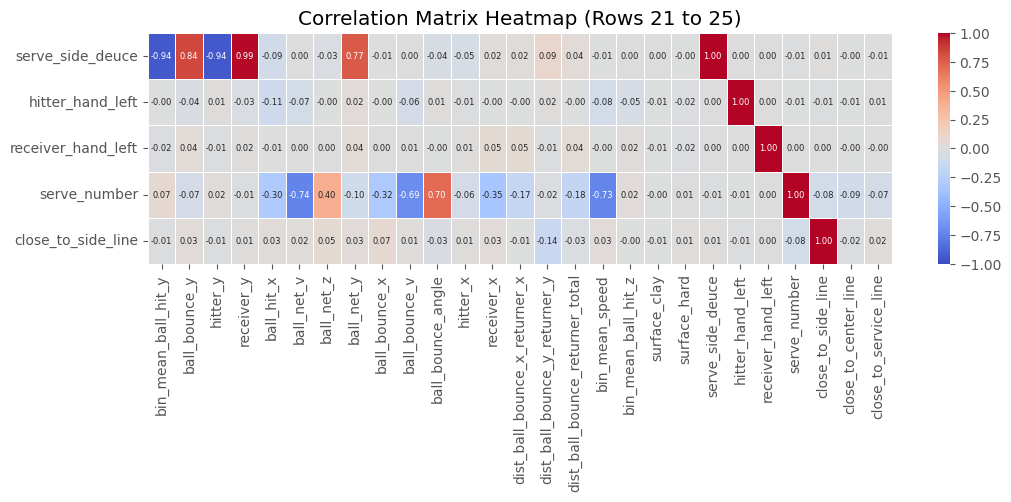

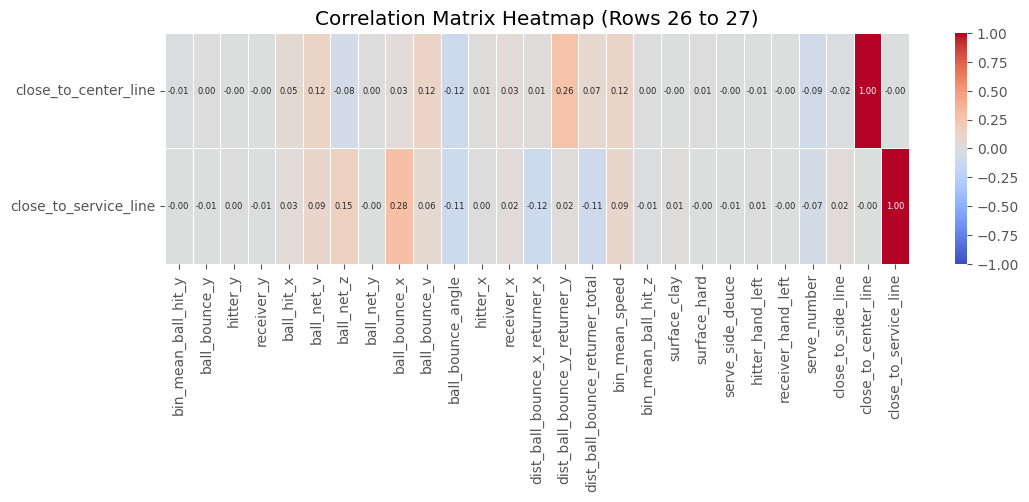

In [32]:
# Display correlation matrix in chunks
dataframe_utils.display_correlation_in_chunks(correlation_matrix, 5)


- Dropping feature 'hitter_y' since it is highly correlated with 'bin_mean_ball_hit_y', which makes sense.
- Dropping feature 'ball_net_y' since it is highly correlated with 'ball_bounce_y'
- Dropping feature 'ball_bounce_v' since it is highly correlated with 'bin_mean_speed'
- Dropping feature 'dist_ball_bounce_returner_total' since it is highly correlated with 'dist_ball_bounce_x_returner_x'. 
- Dropping feature 'ball_net_v' since it is highly correlated with 'ball_hit_v'
- Dropping feature 'serve_side_deuce' as it is highly correlated with 'receiver_y'


In [29]:
df.columns

Index(['ball_hit_y', 'ball_bounce_y', 'hitter_y', 'receiver_y', 'ball_hit_x',
       'ball_hit_z', 'ball_hit_v', 'ball_net_v', 'ball_net_z', 'ball_net_y',
       'ball_bounce_x', 'ball_bounce_v', 'ball_bounce_angle', 'hitter_x',
       'receiver_x', 'dist_ball_bounce_x_returner_x',
       'dist_ball_bounce_y_returner_y', 'dist_ball_bounce_returner_total',
       'bin_mean_speed', 'surface_clay', 'surface_hard', 'serve_side_deuce',
       'hitter_hand_left', 'receiver_hand_left', 'serve_number',
       'close_to_side_line', 'close_to_center_line', 'close_to_service_line'],
      dtype='object')

In [ ]:
# Drop these columns from the data
columns_to_drop = [
    "hitter_y",
    "dist_ball_bounce_returner_total",
    "ball_net_v",
    "ball_net_y",
    "ball_bounce_v",
    "serve_side_deuce",
]
df = df.drop(columns=columns_to_drop)

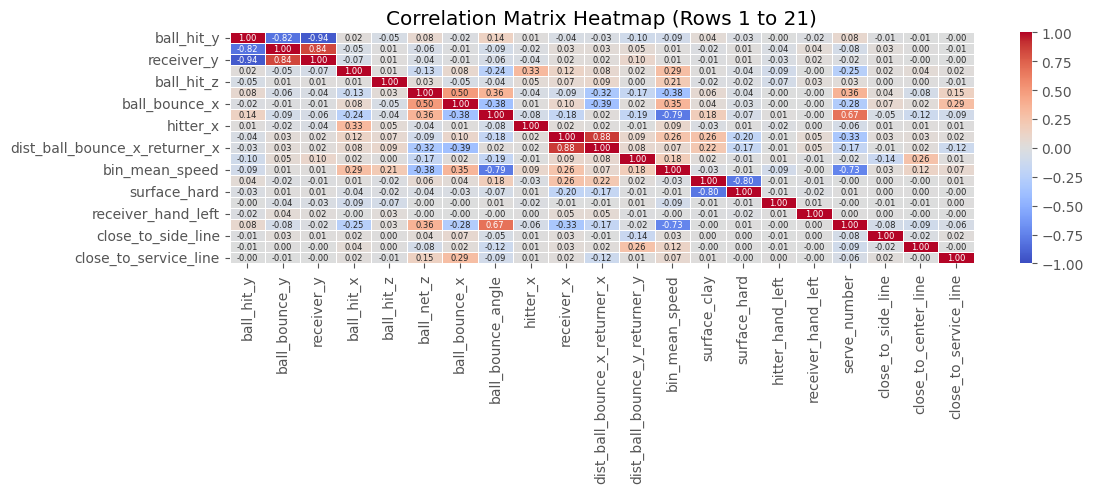

In [34]:
dataframe_utils.display_correlation_in_chunks(df.corr())